In [1]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [2]:
datacsv          = "colombia_may27/"
data_country     = "country_data/"
list_csv         = os.listdir(datacsv)

In [3]:
baseline = read_csv(datacsv+"OD_baseline_Colombia.csv")
baseline.index = baseline.Name
baseline["O"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))
baseline["D"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))

## Calculation of costs with weights for nodes based on the gravity model

### calculates weights for each node

In [4]:
nodes1 = read_excel(data_country+"NODE_CID.xlsx","NODES_CID")
nodes2 = read_excel(data_country+"NODES_10km_TPDA_COL.xlsx","10km_TPDA")

nodes = merge(nodes1, nodes2, on='CID', how='outer')

#### the function below calculates the weight of a OD pair based on the gravity model

In [5]:
baseline["Ot"] = baseline.O.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Dt"] = baseline.D.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Opop"] = baseline.O.replace(nodes.set_index('CID')["Population Headcount"])
baseline["Dpop"] = baseline.D.replace(nodes.set_index('CID')["Population Headcount"])

#### here we calculate losses for each scenario

In [6]:
baseline.ix[baseline.Total_KM!=0,'weights']=baseline.ix[baseline.Total_KM!=0,'Ot']\
                                            *baseline.ix[baseline.Total_KM!=0,'Dt']\
                                            /baseline.ix[baseline.Total_KM!=0,'Total_KM']**2
baseline.weights.fillna(0,inplace=True)

In [7]:
info_links = read_excel(data_country+"Traffic_Link_Final_COL_jun03.xlsx","Traffic_Link_Final")
#info_links = read_excel(datacsv+"allinfo.xlsx","Traffic_Link_AllInfo")

In [8]:
info_links.columns

Index(['NAME_0', 'STATUS', 'INTERVEN', 'CLASS', 'LANES', 'TPDA', 'OD',
       'CODIGO', 'CORR_ID', 'KM', 'pop', 'CITY_NAME', 'ADMIN_NAME',
       'CNTRY_NAME', 'STATUS_1', 'BUFF_DIST', 'TERRAIN', 'SURFACE1', 'COUNTRY',
       'COND1', 'TRAFFIC', 'Ta_ruc', 'Ta_voc', 'OPTIMAL', 'ScenarioID',
       'EU_historical_RP5 (dm)', 'EU_historical_RP10 (dm)',
       'EU_historical_RP25 (dm)', 'EU_historical_RP50 (dm)',
       'EU_historical_RP100 (dm)', 'EU_historical_RP250 (dm)',
       'EU_historical_RP500 (dm)', 'EU_historical_RP1000 (dm)',
       'GFDL_8.5_RP5 (dm)', 'GFDL_8.5_RP10 (dm)', 'GFDL_8.5_RP25 (dm)',
       'GFDL_8.5_RP50 (dm)', 'GFDL_8.5_RP100 (dm)', 'GFDL_8.5_RP250 (dm)',
       'GFDL_8.5_RP500 (dm)', 'GFDL_8.5_RP1000 (dm)', 'HadGEM2_8.5_RP5 (dm)',
       'HadGEM2_8.5_RP10 (dm)', 'HadGEM2_8.5_RP25 (dm)',
       'HadGEM2_8.5_RP50 (dm)', 'HadGEM2_8.5_RP100 (dm)',
       'HadGEM2_8.5_RP250 (dm)', 'HadGEM2_8.5_RP500 (dm)',
       'HadGEM2_8.5_RP1000 (dm)', 'IPSL_8.5_RP5 (dm)', 'IPSL_8

In [9]:
if os.path.exists("costs_colombia_may27.csv"):
    costs_all = read_csv("costs_colombia_may27.csv")
else:
    costs_all = DataFrame(columns=["scenarioID","partial_or_full","part_ruc_increase","ruc_increase","missingroutes",\
                               "num_aff_routes","cost_with_traffic","km_diff"])
    for file in list_csv:
        if ".csv" not in file:
            continue
        if file=="OD_baseline_Colombia.csv":
            continue
        if ("cluster" in file):
            continue
        if ("Partial_V2" in file):
            partial_or_full="partial"
            n      = int(re.search('Scenario_OD(.*)_Partial_V2.csv', file).group(1))
            part_ruc_increase = 0.05
        elif ("Partial_v1" in file):
            partial_or_full="partial"
            n      = int(re.search('Scenario_OD(.*)_Partial_v1.csv', file).group(1))
            part_ruc_increase = 0.5
        else:
            partial_or_full='full'
            n      = int(re.search('OD_scenario(.*).csv', file).group(1))
            part_ruc_increase = 0.
        scenar = read_csv(datacsv+file)
        scenar.index = scenar.Name
        scenar.rename(columns={'Total_Ta_R':'Total_Ta_r'},inplace=True)
        
        missingroutes = len(baseline)-len(scenar)
        # we do not take into account the routes that don't have a second best solution
        baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
        # we select only routes that get affected by the disruption
        affected_routes = (np.round(scenar.Total_Ta_r/baseline_nm.Total_Ta_r,5)!=1)&(baseline_nm.Total_Ta_r>0)
        if sum(affected_routes)>0:
            subscenar = scenar.ix[affected_routes,:]
            subscenar["weights"] = baseline_nm.weights

            traffic = info_links.ix[info_links.ScenarioID,"TPDA"].values[0]

            diff_ruc_baseline   = (subscenar.Total_Ta_r-\
                                   baseline_nm.ix[affected_routes,"Total_Ta_r"])
            diff_km_from_baseline = (subscenar.Total_KM-baseline_nm.ix[affected_routes,"Total_KM"])
            diff_tot_baseline   = (traffic*diff_ruc_baseline)

            ruc_increase      = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
            km_diff = np.sum(diff_km_from_baseline*subscenar.weights)/subscenar.weights.sum()
            cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

            costs_all.loc[len(costs_all),:] = [n,partial_or_full,part_ruc_increase,\
                                               ruc_increase,missingroutes,sum(affected_routes),\
                                               cost_with_traffic,km_diff]
        else:
            costs_all.loc[len(costs_all),:] = [n,partial_or_full,part_ruc_increase,\
                                               0,0,sum(affected_routes),\
                                               0,0]

    costs_all.to_csv("costs_colombia_may27.csv",index=False)

here I merge the info that CJ sent with the results of the analysis (calculation of disruption costs)

In [10]:
allinfo = merge(info_links, costs_all.rename(columns={"scenarioID":"ScenarioID"}), on='ScenarioID', how='inner')
allinfo.index=allinfo.ScenarioID

In [11]:
allinfo.to_csv("allinfo_colombia.csv",index=False)

### Graphs 

In [12]:
figures = "figures/"
if not os.path.exists(figures):
    os.makedirs(pngfolder)

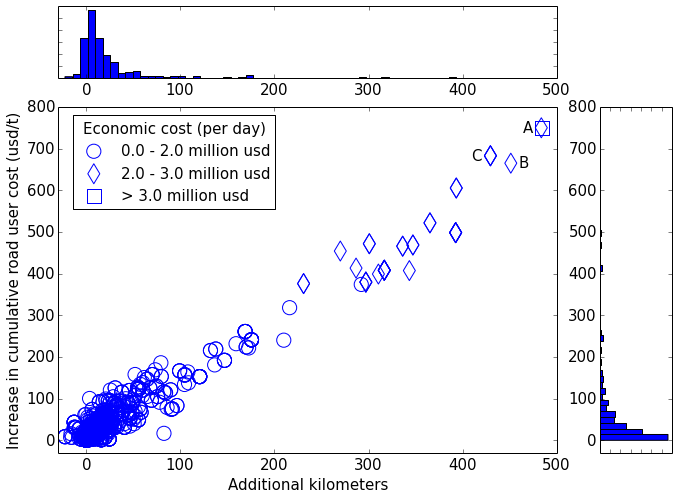

In [40]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(11,8))

x = allinfo.ix[allinfo.partial_or_full=='full','km_diff'].astype(float)
y = allinfo.ix[allinfo.partial_or_full=='full','ruc_increase'].astype(float)
z = allinfo.ix[allinfo.partial_or_full=='full','cost_with_traffic'].astype(float)

groupnum = 3

axScatter = plt.subplot(111)
#axScatter.scatter(x,y,s=10**(-4)*costs['max cost with traffic (usd)'],facecolors='none',edgecolors='blue')
binsz = np.linspace(z.min(), z.max(), groupnum)
grouped = allinfo.ix[allinfo.partial_or_full=='full',:].groupby(np.digitize(z, binsz))

# Create some sizes and some labels.
sizes = [100*(i+1.) for i in range(groupnum+1)]
markers = ['o','d','s']
forleg = np.round(binsz*10**(-6))
labels = ["{} - {} million usd".format(forleg[i],forleg[i+1]) for i in range(groupnum-1)]+\
["> {} million usd".format(forleg[-1])]

for i, (name, group) in enumerate(grouped):
    axScatter.scatter(group.km_diff, group.ruc_increase, \
                      s=200, alpha=1, marker=markers[i], label=labels[i],facecolors='none',edgecolors='blue')
    
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in cumulative road user cost (usd/t)")
#axScatter.set_aspect(1.)

# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", size=1., pad=0.4, sharex=axScatter)
axHisty = divider.append_axes("right", size=1., pad=0.6, sharey=axScatter)

# the scatter plot:
# histograms
binsx = np.arange(x.min(), x.max() + 10, 8)
binsy = np.arange(y.min(), y.max() + 10, 14)
axHistx.hist(x, bins=binsx)
axHistx.yaxis.set_ticklabels([])
axHisty.hist(y, bins=binsy, orientation='horizontal')
axHisty.xaxis.set_ticklabels([])

axScatter.legend(bbox_to_anchor=[-0.05,0.5,0.5,0.5],frameon=True,fontsize=15,title="Economic cost (per day)",\
                 scatterpoints=1)

axScatter.set_ylim([-30,800])
axScatter.set_xlim([-30,500])

axScatter.annotate("A",xy=(x.loc[482]-20,y.loc[482]-10))
axScatter.annotate("B",xy=(x.loc[566]+10,y.loc[566]-10))
axScatter.annotate("C",xy=(x.loc[505]-20,y.loc[505]-10))

plt.savefig(figures+"col_all_costs_hist_noflood.png",bbox_inches="tight",dpi=100)

A = [482, 975, 976]

B = 566

C = [505, 589, 873]

In [28]:
allinfo.ix[(allinfo.km_diff>451)&(allinfo.km_diff<452),"km_diff"].index

Int64Index([566], dtype='int64', name='ScenarioID')

In [22]:
allinfo.ix[(allinfo.km_diff>480)&(allinfo.km_diff>400),"km_diff"].index

Int64Index([482, 975, 976], dtype='int64', name='ScenarioID')

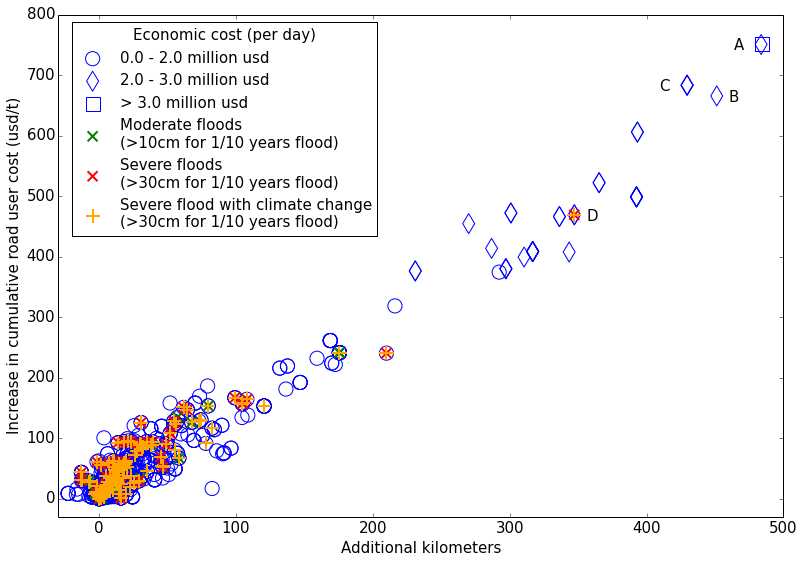

In [47]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(13,9))

x = allinfo.ix[allinfo.partial_or_full=='full','km_diff'].astype(float)
y = allinfo.ix[allinfo.partial_or_full=='full','ruc_increase'].astype(float)
z = allinfo.ix[allinfo.partial_or_full=='full','cost_with_traffic'].astype(float)

groupnum = 3

axScatter = plt.subplot(111)
#axScatter.scatter(x,y,s=10**(-4)*costs['max cost with traffic (usd)'],facecolors='none',edgecolors='blue')
binsz = np.linspace(z.min(), z.max(), groupnum)
grouped = allinfo.ix[allinfo.partial_or_full=='full',:].groupby(np.digitize(z, binsz))

# Create some sizes and some labels.
sizes = [100*(i+1.) for i in range(groupnum+1)]
markers = ['o','d','s']
forleg = np.round(binsz*10**(-6))
labels = ["{} - {} million usd".format(forleg[i],forleg[i+1]) for i in range(groupnum-1)]+\
["> {} million usd".format(forleg[-1])]

for i, (name, group) in enumerate(grouped):
    axScatter.scatter(group.km_diff, group.ruc_increase, \
                      s=200, alpha=1, marker=markers[i], label=labels[i],facecolors='none',edgecolors='blue')
    
select2 = ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])>1)&\
          ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])<3)
axScatter.scatter(x[select2],y[select2],marker="x",s=100,linewidth=2,\
                  c="green",label="Moderate floods\n(>10cm for 1/10 years flood)")

select = ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])>3)
axScatter.scatter(x[select],y[select],marker="x",s=100,linewidth=2,\
                  c="red",label="Severe floods\n(>30cm for 1/10 years flood)")

selectcc = ((allinfo.ix[allinfo.partial_or_full=='full',"GFDL_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>3)|\
((allinfo.ix[allinfo.partial_or_full=='full',"HadGEM2_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>3)|\
((allinfo.ix[allinfo.partial_or_full=='full',"IPSL_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>3)
axScatter.scatter(x[selectcc],y[selectcc],marker="+",s=200,\
                  facecolors='none',edgecolors='orange',linewidth=2,label="Severe flood with climate change\n(>30cm for 1/10 years flood)")

    
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in cumulative road user cost (usd/t)")
#axScatter.set_aspect(1.)

axScatter.legend(bbox_to_anchor=[-0.05,0.5,0.5,0.5],frameon=True,fontsize=15,title="Economic cost (per day)",\
                 scatterpoints=1)

axScatter.set_ylim([-30,800])
axScatter.set_xlim([-30,500])

axScatter.annotate("A",xy=(x.loc[482]-20,y.loc[482]-10))
axScatter.annotate("B",xy=(x.loc[566]+10,y.loc[566]-10))
axScatter.annotate("C",xy=(x.loc[505]-20,y.loc[505]-10))

axScatter.annotate("D",xy=(x.loc[291]+10,y.loc[291]-10))

plt.savefig(figures+"col_all_costs_nohist_flood.png",bbox_inches="tight",dpi=80)

In [45]:
allinfo.ix[(allinfo.km_diff>300)&selectcc,"km_diff"].index

Int64Index([291], dtype='int64', name='ScenarioID')

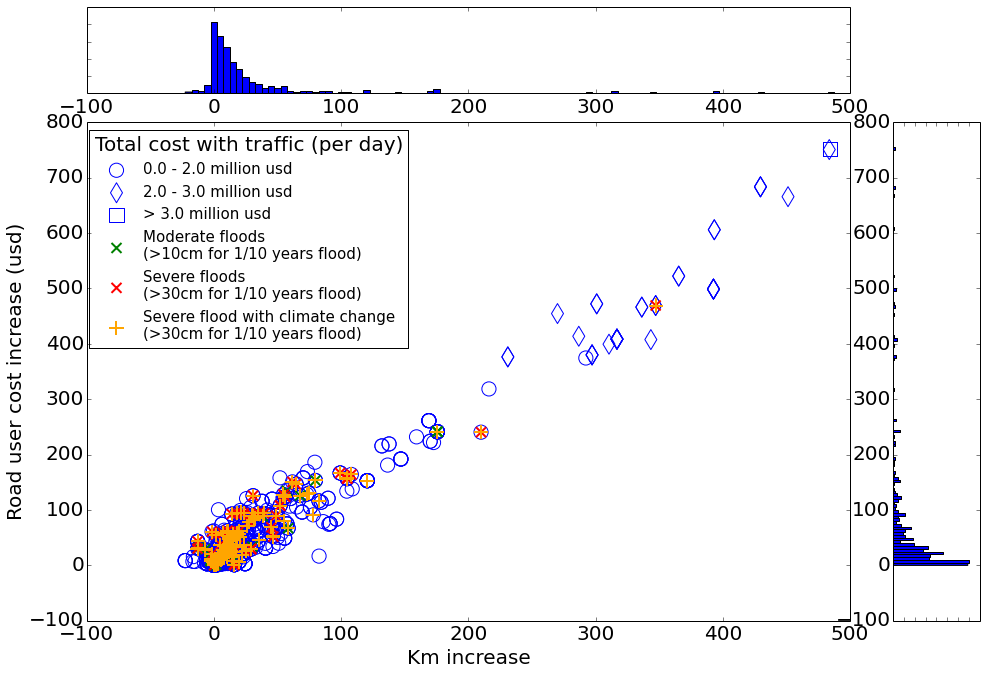

In [15]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.figure(figsize=(16,11))

x = allinfo.ix[allinfo.partial_or_full=='full','km_diff'].astype(float)
y = allinfo.ix[allinfo.partial_or_full=='full','ruc_increase'].astype(float)
z = allinfo.ix[allinfo.partial_or_full=='full','cost_with_traffic'].astype(float)

groupnum = 3

axScatter = plt.subplot(111)
#axScatter.scatter(x,y,s=10**(-4)*costs['max cost with traffic (usd)'],facecolors='none',edgecolors='blue')
binsz = np.linspace(z.min(), z.max(), groupnum)
grouped = allinfo.ix[allinfo.partial_or_full=='full',:].groupby(np.digitize(z, binsz))

# Create some sizes and some labels.
sizes = [100*(i+1.) for i in range(groupnum+1)]
markers = ['o','d','s']
forleg = np.round(binsz*10**(-6))
labels = ["{} - {} million usd".format(forleg[i],forleg[i+1]) for i in range(groupnum-1)]+\
["> {} million usd".format(forleg[-1])]

for i, (name, group) in enumerate(grouped):
    axScatter.scatter(group.km_diff, group.ruc_increase, \
                      s=200, alpha=1, marker=markers[i], label=labels[i],facecolors='none',edgecolors='blue')

select2 = ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])>1)&\
          ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])<3)
axScatter.scatter(x[select2],y[select2],marker="x",s=100,linewidth=2,\
                  c="green",label="Moderate floods\n(>10cm for 1/10 years flood)")

select = ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])>3)
axScatter.scatter(x[select],y[select],marker="x",s=100,linewidth=2,\
                  c="red",label="Severe floods\n(>30cm for 1/10 years flood)")

selectcc = ((allinfo.ix[allinfo.partial_or_full=='full',"GFDL_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>3)|\
((allinfo.ix[allinfo.partial_or_full=='full',"HadGEM2_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>3)|\
((allinfo.ix[allinfo.partial_or_full=='full',"IPSL_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>3)
axScatter.scatter(x[selectcc],y[selectcc],marker="+",s=200,\
                  facecolors='none',edgecolors='orange',linewidth=2,label="Severe flood with climate change\n(>30cm for 1/10 years flood)")

plt.xlabel("Km increase")
plt.ylabel("Road user cost increase (usd)")

divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", size=1.2, pad=0.4, sharex=axScatter)
axHisty = divider.append_axes("right", size=1.2, pad=0.6, sharey=axScatter)

# the scatter plot:
# histograms
binsx = np.arange(x.min(), x.max() + 10, 5)
binsy = np.arange(y.min(), y.max() + 10, 5)
axHistx.hist(x, bins=binsx)
axHistx.yaxis.set_ticklabels([])
axHisty.hist(y, bins=binsy, orientation='horizontal')
axHisty.xaxis.set_ticklabels([])

axScatter.legend(bbox_to_anchor=[-0.07,0.5,0.5,0.5],frameon=True,fontsize=15,title="Total cost with traffic (per day)",\
                 scatterpoints=1)

plt.savefig(figures+"col_all_costs.png",bbox_inches="tight",dpi=400)

In [68]:
sum(selectcc)

71